# CNN Encoder LSTM Architecture

## Read About Timedistributed Layer
https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/


# The Simplest CNN Encoder + LSTM Model
In this exercise we will apply time distributed 1D convolution on the sinusoidal time series and then apply lstm

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt

### Generate Noise Sin Values

In [0]:
def noisy_sin(steps_per_cycle = 50,
              number_of_cycles = 500,
              random_factor = 0.4):
  '''
  random_factor    : amont of noise in sign wave. 0 = no noise
  number_of_cycles : The number of steps required for one cycle

  Return : 
  pd.DataFrame() with column sin_t containing the generated sin wave 
  '''
  random.seed(0)
  df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
  df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
  df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
  print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
  print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
  return(df)

create period-10 sin wave with 500 cycles
In total, the sin wave time series length is 5001


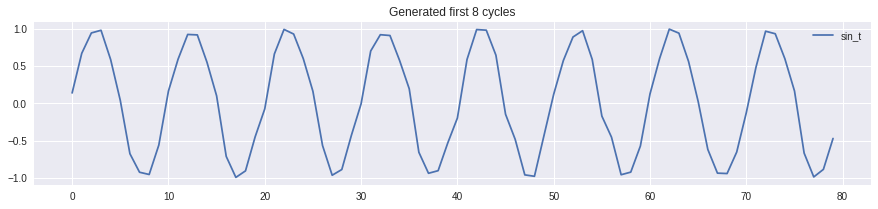

In [3]:
steps_per_cycle = 10

df = noisy_sin(steps_per_cycle=steps_per_cycle,
              random_factor = 0.2)

n_plot = 8
df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="Generated first {} cycles".format(n_plot),
      figsize=(15,3))

### Split Train / Test Data

In [13]:
def _load_data(data, n_prev = 100):  
  """
  data should be pd.DataFrame()
  """

  docX, docY = [], []
  for i in range(len(data)-n_prev):
      docX.append(data.iloc[i:i+n_prev].as_matrix())
      docY.append(data.iloc[i+n_prev].as_matrix())
  alsX = np.array(docX)
  alsY = np.array(docY)

  return alsX, alsY

length_of_sequences = 10
test_size = 0.25

ntr = int(len(df) * (1 - test_size))

df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
X_train = X_train.reshape(-1, X_train.shape[1:][0], X_train.shape[1:][1],1)

(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
X_test = X_test.reshape(-1, X_test.shape[1:][0], X_test.shape[1:][1],1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3740, 10, 1, 1) (3740, 1) (1241, 10, 1, 1) (1241, 1)


## Conv 1D + LSTM Model
### Build Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed


model = Sequential()

# Conv 1D will act like smoothing filter

model.add(
  TimeDistributed(
      Conv1D(64, (2), padding='same', activation='relu'), 
      input_shape=(10,1,1)
  )
)

model.add(TimeDistributed(Flatten()))

model.add(LSTM(32, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="rmsprop")
  
## use the default values for batch_size, stateful
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 10, 1, 64)         192       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 14,309
Trainable params: 14,309
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [23]:
hist = model.fit(X_train, y_train, batch_size=600, epochs=100, 
                 verbose=True,validation_split=0.05)

Train on 3553 samples, validate on 187 samples
Epoch 1/100
3553/3553 [==============================] - 2s 497us/step - loss: 0.4938 - val_loss: 0.4696
Epoch 2/100
3553/3553 [==============================] - 0s 92us/step - loss: 0.4471 - val_loss: 0.3981
Epoch 3/100
3553/3553 [==============================] - 0s 91us/step - loss: 0.3463 - val_loss: 0.2543
Epoch 4/100
3553/3553 [==============================] - 0s 92us/step - loss: 0.1849 - val_loss: 0.0901
Epoch 5/100
3553/3553 [==============================] - 0s 94us/step - loss: 0.0529 - val_loss: 0.0279
Epoch 6/100
3553/3553 [==============================] - 0s 93us/step - loss: 0.0246 - val_loss: 0.0141
Epoch 7/100
3553/3553 [==============================] - 0s 91us/step - loss: 0.0145 - val_loss: 0.0153
Epoch 8/100
3553/3553 [==============================] - 0s 93us/step - loss: 0.0180 - val_loss: 0.0120
Epoch 9/100
3553/3553 [==============================] - 0s 92us/step - loss: 0.0123 - val_loss: 0.0115
Epoch 10/100
355

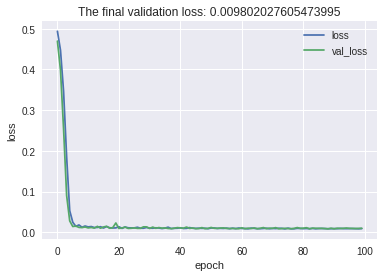

In [24]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

### Predict Model

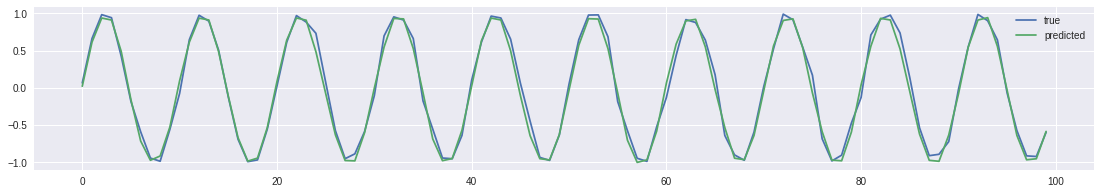

In [25]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_test[:100],label="true")
plt.plot(y_pred[:100],label="predicted")
plt.legend()
plt.show()